Creating txt files  

In [2]:
import os
import random

from IPython.core.pylabtools import figsize
from PIL.ImageColor import colormap
from faker import Faker
from sklearn.metrics import accuracy_score


def generate_random_text(size, language = 'en'):
    fake = Faker(language)
    words = []
    while sum(len(w) for w in words) + len(words) - 1 < size:
        words.append(fake.word())
        
    return ' '.join(words)[:size]

def create_txt_files(num_of_files = 1000, min_size = 300, max_size = 10000, output_dir = 'generated_txts_1000', language = 'en'):
    os.makedirs(output_dir, exist_ok=True)
    
    for i in range(1, num_of_files + 1):
        size = random.randint(min_size, max_size)
        text = generate_random_text(size, language) 
        filename = os.path.join(output_dir, f'file{i:04d}.txt')
        
        with open(filename, 'w', encoding='utf-8') as f:
            f.write(text)
            
    print(f"Generated {num_of_files} files. Saved in directory '{output_dir}'")
    
create_txt_files()

KeyboardInterrupt: 

Encryption of 1000 txt files with AES, DES, 3DES, RC4 in ECB mode

In [5]:
import os
from Crypto.Cipher import AES, DES, DES3, ARC4
from Crypto.Util.Padding import pad
from Crypto.Random import get_random_bytes

def encrypt_ecb(algorithm, key, plaintext):
    if algorithm == 'AES':
        cipher = AES.new(key, AES.MODE_ECB)
        return cipher.encrypt(pad(plaintext, AES.block_size))
    elif algorithm == 'DES':
        cipher = DES.new(key, DES.MODE_ECB)
        return cipher.encrypt(pad(plaintext, DES.block_size))
    elif algorithm == 'DES3':
        cipher = DES3.new(key, DES.MODE_ECB)
        return cipher.encrypt(pad(plaintext, DES3.block_size))
    elif algorithm == 'ARC4':
        cipher = ARC4.new(key)
        return cipher.encrypt(plaintext)

def encrypt_file_ecb(input_dir='generated_txts_1000', output_dir='encrypted_txts_1000_ecb'):
    os.makedirs(output_dir, exist_ok=True)

    algorithms = {
        'AES': 30,
        'DES': 25,
        'DES3': 20,
        'ARC4': 15,
        'NONE': 10
    }

    keys = {
        'AES': get_random_bytes(16),
        'DES': get_random_bytes(8),
        'DES3': DES3.adjust_key_parity(get_random_bytes(24)),
        'ARC4': get_random_bytes(16),
    }

    file_list = sorted(os.listdir(input_dir))   
    total_files = len(file_list)
    assigned_files = 0

    for algo, percentage in algorithms.items():
        algo_count = int((percentage / 100) * total_files)
        algo_dir = os.path.join(output_dir, algo) 
        os.makedirs(algo_dir, exist_ok=True)

        for _ in range(algo_count):
            if assigned_files >= total_files:
                break
            file_name = file_list[assigned_files]
            input_path = os.path.join(input_dir, file_name)
            output_path = os.path.join(algo_dir, file_name + '.enc')  

            if os.path.isdir(input_path):  
                continue  

            with open(input_path, 'rb') as f:
                plain_text = f.read()
                if algo != 'NONE':
                    cipher_text = encrypt_ecb(algo, keys[algo], plain_text)
                    with open(output_path, 'wb') as f_encrypted:
                        f_encrypted.write(cipher_text)
                else:
                    os.rename(input_path, os.path.join(algo_dir, file_name))

            assigned_files += 1

    print(f"Encrypted all files. Saved in directory '{output_dir}'")

encrypt_file_ecb()


Encrypted all files. Saved in directory 'encrypted_txts_1000_ecb'


In [6]:
aes_len = len(os.listdir('encrypted_txts_1000_ecb/AES'))
arc4_len = len(os.listdir('encrypted_txts_1000_ecb/ARC4'))
des_len = len(os.listdir('encrypted_txts_1000_ecb/DES'))
des3_len = len(os.listdir('encrypted_txts_1000_ecb/DES3'))
none_len = len(os.listdir('encrypted_txts_1000_ecb/NONE'))

print(f"{aes_len} AES Files")
print(f"{arc4_len} ARC4 Files")
print(f"{des3_len} 3DES Files")
print(f"{des_len} DES Files")
print(f"{none_len} NONE")

300 AES Files
225 ARC4 Files
255 3DES Files
280 DES Files
190 NONE


Create dataframe based on encrypted files with pandas 

In [4]:
import pandas as pd
import numpy as np
import scipy 
from collections import Counter
from math import log2
import os

def calculate_entropy(byte_data):
    if len(byte_data) == 0:  
        return 0
    counts = Counter(byte_data)
    length = len(byte_data)
    return -sum((freq / length) * log2(freq / length) for freq in counts.values())


def extract_values(file_path):
    with open(file_path, 'rb') as f:
        byte_data = f.read()
    
    if not byte_data:
        return None
    
    byte_array = np.frombuffer(byte_data, dtype=np.uint8)
    
    entropy = calculate_entropy(byte_array)
    mean = np.mean(byte_array)
    variance = np.var(byte_array)
    std_dev = np.std(byte_array)
    skewness = scipy.stats.skew(byte_array)
    kurtosis = scipy.stats.kurtosis(byte_array)
    energy = np.sum(byte_array ** 2)
    rms = np.sqrt(np.mean(byte_array  ** 2))
    
    hist, _ = np.histogram(byte_array, bins=256, range=(0, 256))
    
    return [entropy, mean, variance, std_dev, skewness, kurtosis, energy, rms] + hist.tolist()

def process_encrypted_files(input_dir, output_csv):
    data = []
    
    for algo in os.listdir(input_dir):
        algo_dir = os.path.join(input_dir, algo)
        if not os.path.isdir(algo_dir):
            continue
            
        for file_name in os.listdir(algo_dir):
            file_path = os.path.join(algo_dir, file_name)
            features = extract_values(file_path)
            if features:
                data.append([file_name] + features + [algo])
                
    columns = [
        "file_name", "entropy", "mean", "variance", "std_dev", "skewness", "kurtosis", "energy", "rms"
    ] + [f"histogram_{i}" for i in range(256)] + ["algorithm"]
    
    df = pd.DataFrame(data, columns=columns)
    df.to_csv(output_csv, index=False)
    print(f"Saved extracted features to {output_csv}")
    
input_directory = 'encrypted_txts_1000_ecb'
output_csv = 'encrypted_features_txt_1000_ecb.csv'
process_encrypted_files(input_directory, output_csv)

Saved extracted features to encrypted_features_txt_1000_ecb.csv


In [7]:
import pandas as pd

df = pd.read_csv('encrypted_features_txt_1000_ecb.csv')
df

,file_name,entropy,mean,variance,std_dev,skewness,kurtosis,energy,rms,histogram_0,...,histogram_247,histogram_248,histogram_249,histogram_250,histogram_251,histogram_252,histogram_253,histogram_254,histogram_255,algorithm
0,file0359.txt.enc,7.874751,126.502703,5426.840533,73.667093,0.010801,-1.201622,159202,10.371544,3,...,4,6,5,6,4,7,4,4,2,DES
1,file0349.txt.enc,7.947062,126.474722,5538.406583,74.420472,0.028584,-1.196003,379535,10.267735,14,...,21,14,19,21,13,14,11,15,10,DES
2,file0474.txt.enc,7.976434,128.381337,5502.731549,74.180399,-0.003547,-1.203000,963290,10.259366,40,...,44,42,36,43,38,42,37,34,48,DES
3,file0464.txt.enc,7.894732,125.666492,5459.260096,73.886806,0.046188,-1.204116,193215,10.073652,6,...,5,4,11,7,7,8,8,11,5,DES
4,file0416.txt.enc,7.975843,128.416190,5454.062770,73.851627,-0.012061,-1.186151,740818,10.293310,23,...,28,29,31,31,35,25,31,30,29,DES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,file0058.txt.enc,7.979534,127.781647,5522.520040,74.313660,-0.010099,-1.211684,924013,10.237720,34,...,35,36,33,49,38,37,36,32,31,AES
996,file0256.txt.enc,7.974408,126.648401,5417.036698,73.600521,0.019118,-1.189063,721141,10.238018,30,...,22,31,36,27,35,25,25,15,24,AES
997,file0246.txt.enc,7.919591,127.221000,5233.212159,72.340944,0.018650,-1.162764,215862,10.388985,7,...,8,4,7,3,5,8,9,8,5,AES
998,file0189.txt.enc,7.834612,128.444079,5493.592268,74.118771,0.025633,-1.167368,128384,10.275162,6,...,5,8,1,7,7,4,9,6,13,AES


Comparison of histograms by encryption algorithms

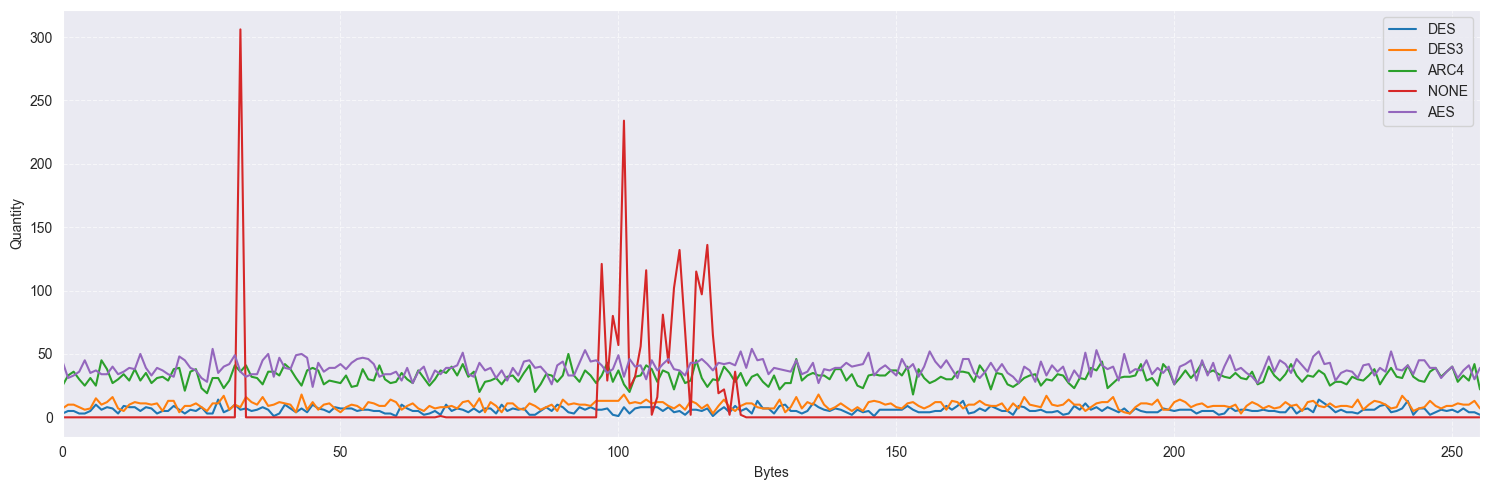

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
for i, algo in enumerate(df["algorithm"].unique()):
    subset = df[df["algorithm"] == algo].iloc[0, 9:265]
    plt.plot(range(256), subset, label=algo)

plt.xlim(0, 255)
plt.xlabel("Bytes")
plt.ylabel("Quantity")
plt.legend()
plt.title("")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.savefig("histogram_test.png", dpi=300)
plt.show()


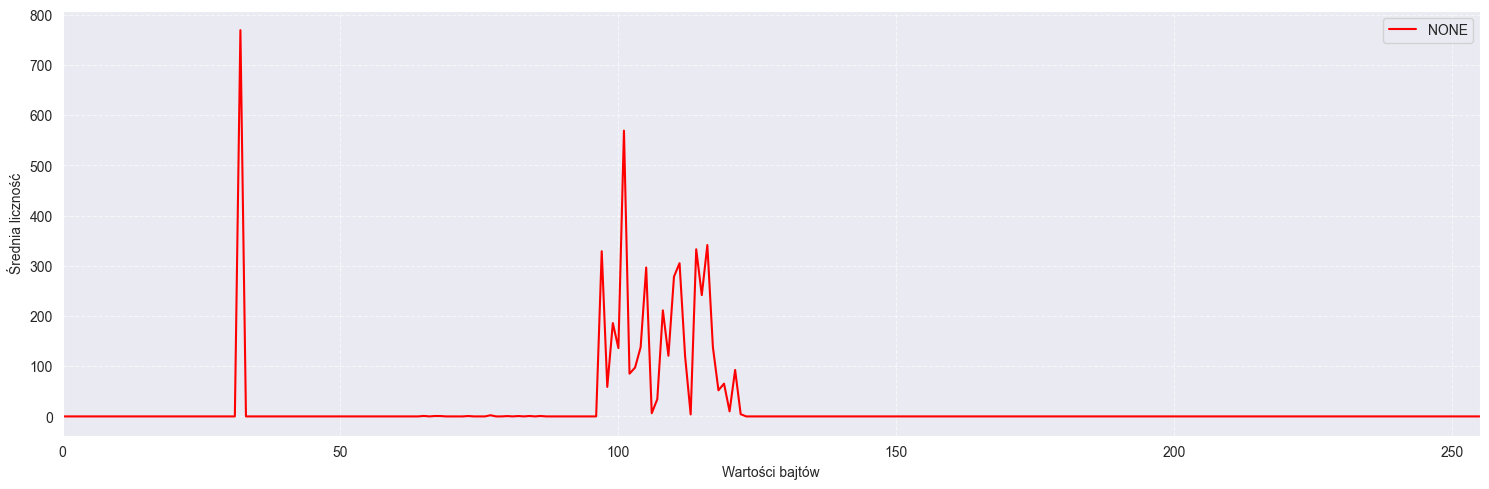

In [21]:
subset_none = df[df["algorithm"] == "NONE"]
avg_hist_none = subset_none.iloc[:, 9:265].mean()

plt.figure(figsize=(15, 5))
plt.xlim(0, 255)
plt.plot(range(256), avg_hist_none, color="red", label="NONE")
plt.xlabel("Wartości bajtów")
plt.ylabel("Średnia liczność")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


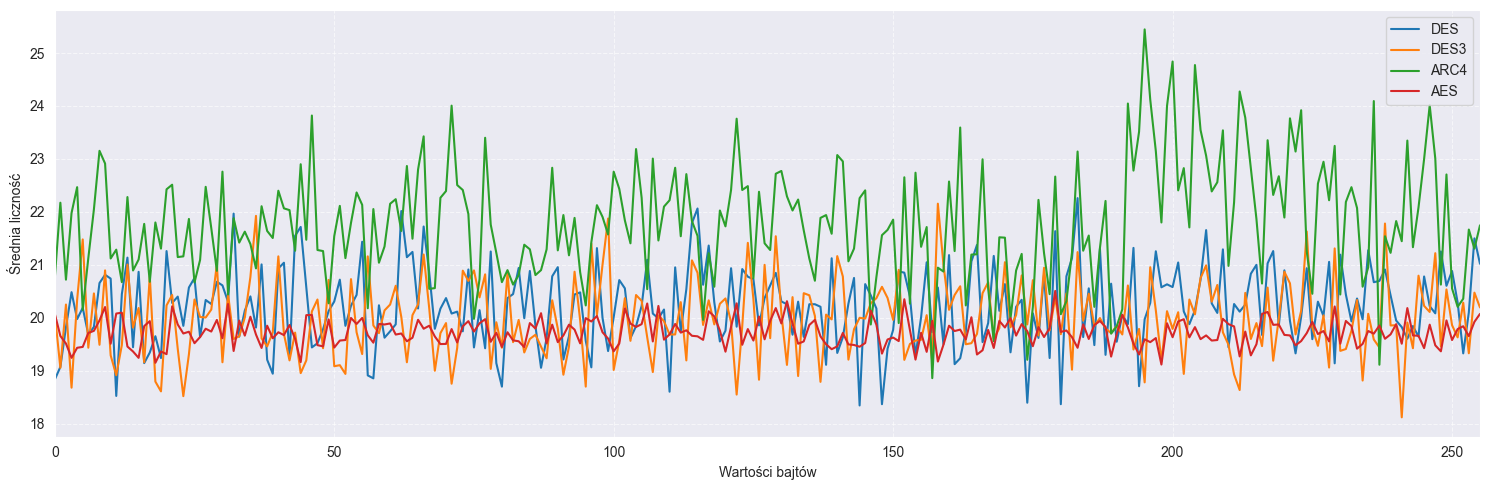

In [22]:
import matplotlib.pyplot as plt

algorithms = df["algorithm"].unique()
algorithms = [algo for algo in algorithms if algo != "NONE"]

plt.figure(figsize=(15, 5))
for algo in algorithms:
    subset = df[df["algorithm"] == algo]
    avg_hist = subset.iloc[:, 9:265].mean()
    plt.plot(range(256), avg_hist, label=algo)
plt.xlim(0, 255)
plt.xlabel("Wartości bajtów")
plt.ylabel("Średnia liczność")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
for i, algo in enumerate(df["algorithm"].unique()):
    subset = df[df["algorithm"] == algo].iloc[0, 9:265]
    plt.plot(range(256), subset, label=algo)

plt.xlim(0, 255)
plt.xlabel("Wartości bajtów")
plt.ylabel("Liczność")
plt.legend()
plt.title("")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

Entropy in ECB mode by encryption algorithms 

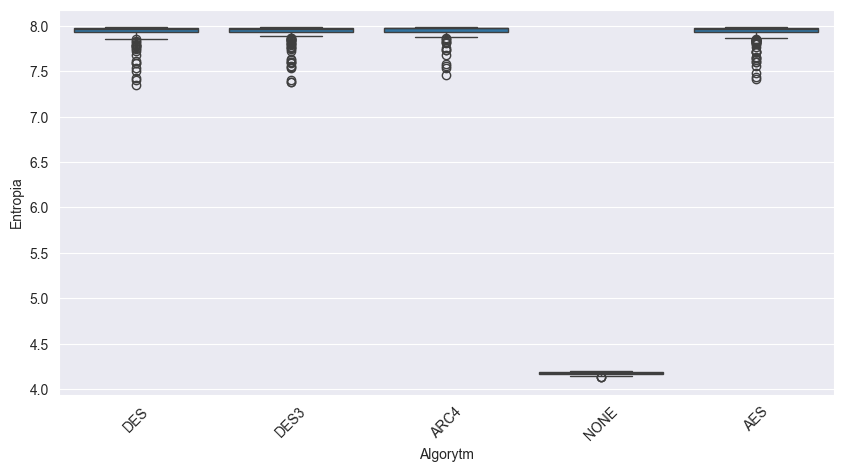

In [24]:
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.boxplot(x=df["algorithm"], y=df["entropy"])
plt.xlabel("Algorytm")
plt.ylabel("Entropia")
plt.xticks(rotation=45)
plt.show()


Data preprocessing before cross-validation

In [8]:
import pandas as pd

data_frame = pd.read_csv('encrypted_features_txt_1000_ecb.csv')
data_frame

,file_name,entropy,mean,variance,std_dev,skewness,kurtosis,energy,rms,histogram_0,...,histogram_247,histogram_248,histogram_249,histogram_250,histogram_251,histogram_252,histogram_253,histogram_254,histogram_255,algorithm
0,file0359.txt.enc,7.874751,126.502703,5426.840533,73.667093,0.010801,-1.201622,159202,10.371544,3,...,4,6,5,6,4,7,4,4,2,DES
1,file0349.txt.enc,7.947062,126.474722,5538.406583,74.420472,0.028584,-1.196003,379535,10.267735,14,...,21,14,19,21,13,14,11,15,10,DES
2,file0474.txt.enc,7.976434,128.381337,5502.731549,74.180399,-0.003547,-1.203000,963290,10.259366,40,...,44,42,36,43,38,42,37,34,48,DES
3,file0464.txt.enc,7.894732,125.666492,5459.260096,73.886806,0.046188,-1.204116,193215,10.073652,6,...,5,4,11,7,7,8,8,11,5,DES
4,file0416.txt.enc,7.975843,128.416190,5454.062770,73.851627,-0.012061,-1.186151,740818,10.293310,23,...,28,29,31,31,35,25,31,30,29,DES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,file0058.txt.enc,7.979534,127.781647,5522.520040,74.313660,-0.010099,-1.211684,924013,10.237720,34,...,35,36,33,49,38,37,36,32,31,AES
996,file0256.txt.enc,7.974408,126.648401,5417.036698,73.600521,0.019118,-1.189063,721141,10.238018,30,...,22,31,36,27,35,25,25,15,24,AES
997,file0246.txt.enc,7.919591,127.221000,5233.212159,72.340944,0.018650,-1.162764,215862,10.388985,7,...,8,4,7,3,5,8,9,8,5,AES
998,file0189.txt.enc,7.834612,128.444079,5493.592268,74.118771,0.025633,-1.167368,128384,10.275162,6,...,5,8,1,7,7,4,9,6,13,AES


Converting algorithm labels to numeric values

In [25]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
data_frame['algorithm'] = encoder.fit_transform(data_frame['algorithm'])
print(encoder.classes_)

[0 1 2 3 4]


Data normalization with MinMaxScaler

In [26]:
from sklearn.preprocessing import MinMaxScaler

X = data_frame.drop(columns=["algorithm", "file_name"])
y = data_frame["algorithm"]

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

Model training and cross validation - StratifiedKFold

In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    log_loss, roc_auc_score
)

models = {
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel="linear", probability=True),
    "NaiveBayes": GaussianNB(),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Bagging": BaggingClassifier(n_estimators=50, random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=50, random_state=42)
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results_list = []
class_results = {model_name: [] for model_name in models}

for model_name, model in models.items():
    acc_scores, precision_scores, recall_scores, f1_scores = [], [], [], []
    log_losses, auc_scores = [], []
    
    for train_index, test_index in skf.split(X_scaled, y):
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]  # dla pandas.DataFrame
        y_train, y_test = y[train_index], y[test_index]

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test) if hasattr(model, "predict_proba") else None

        acc_scores.append(accuracy_score(y_test, y_pred))
        precision_scores.append(precision_score(y_test, y_pred, average='weighted'))
        recall_scores.append(recall_score(y_test, y_pred, average='weighted'))
        f1_scores.append(f1_score(y_test, y_pred, average='weighted'))

        if y_pred_proba is not None:
            log_losses.append(log_loss(y_test, y_pred_proba))
            auc_scores.append(roc_auc_score(y_test, y_pred_proba, multi_class="ovr"))
        else:
            log_losses.append(None)
            auc_scores.append(None)

        class_precision = precision_score(y_test, y_pred, average=None)
        class_recall = recall_score(y_test, y_pred, average=None)
        class_f1 = f1_score(y_test, y_pred, average=None)

        for i, class_label in enumerate(np.unique(y)):
            class_results[model_name].append({
                "Class": class_label,
                "Precision": class_precision[i],
                "Recall": class_recall[i],
                "F1-Score": class_f1[i]
            })

    results_list.append({
        "Model": model_name,
        "Accuracy Mean": np.mean(acc_scores),
        "Accuracy Std": np.std(acc_scores),
        "Precision Mean": np.mean(precision_scores),
        "Precision Std": np.std(precision_scores),
        "Recall Mean": np.mean(recall_scores),
        "Recall Std": np.std(recall_scores),
        "F1-Score Mean": np.mean(f1_scores),
        "F1-Score Std": np.std(f1_scores),
        "Log Loss Mean": np.mean([x for x in log_losses if x is not None]) if any(log_losses) else None,
        "AUC Mean": np.mean([x for x in auc_scores if x is not None]) if any(auc_scores) else None
    })

# Konwersja wyników do DataFrame
df_results = pd.DataFrame(results_list)
df_class_results = pd.DataFrame([
    {"Model": model, **result} for model, results in class_results.items() for result in results
])

# Wyświetlenie tabeli w Jupyter Notebook
df_results.style.format("{:.4f}"), df_class_results.style.format("{:.4f}")


/Users/jakubkowalewski/Desktop/pythonProject-main/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jakubkowalewski/Desktop/pythonProject-main/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jakubkowalewski/Desktop/pythonProject-main/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

(<pandas.io.formats.style.Styler at 0x16aae39a0>,
 <pandas.io.formats.style.Styler at 0x16ab1e910>)

In [28]:
df_results

,Model,Accuracy Mean,Accuracy Std,Precision Mean,Precision Std,Recall Mean,Recall Std,F1-Score Mean,F1-Score Std,Log Loss Mean,AUC Mean
0,RandomForest,0.506,0.020833,0.541320,0.016293,0.506,0.020833,0.485616,0.018531,1.113050,0.799795
1,SVM,0.707,0.026571,0.733075,0.020590,0.707,0.026571,0.708731,0.027347,0.670108,0.926310
2,NaiveBayes,0.345,0.045497,0.387331,0.107580,0.345,0.045497,0.310592,0.053292,12.201060,0.678692
3,KNN,0.465,0.020248,0.466229,0.028096,0.465,0.020248,0.453584,0.025438,5.083309,0.761288
4,Bagging,0.513,0.016912,0.522807,0.027680,0.513,0.016912,0.500591,0.017591,1.079305,0.797024
5,AdaBoost,0.388,0.016310,0.397772,0.024527,0.388,0.016310,0.383317,0.016893,1.586892,0.729728


In [29]:
# Słownik mapujący oryginalne nazwy na polskie
column_translation = {
    "Model": "Model",
    "Accuracy Mean": "Średnia dokładność",
    "Accuracy Std": "Odchylenie standardowe dokładności",
    "Precision Mean": "Średnia precyzja",
    "Precision Std": "Odchylenie standardowe precyzji",
    "Recall Mean": "Średnia czułość",
    "Recall Std": "Odchylenie standardowe czułości",
    "F1-Score Mean": "Średnia F1-Score",
    "F1-Score Std": "Odchylenie standardowe F1-Score",
    "Log Loss Mean": "Średnia strata logarytmiczna",
    "AUC Mean": "Średnia AUC"
}

# Zastosowanie tłumaczenia
df_polish = df_results.rename(columns=column_translation)
#df_polish = df_class_results

# Podgląd
print(df_polish.head())


          Model  Średnia dokładność  Odchylenie standardowe dokładności  \
0  RandomForest               0.506                            0.020833   
1           SVM               0.707                            0.026571   
2    NaiveBayes               0.345                            0.045497   
3           KNN               0.465                            0.020248   
4       Bagging               0.513                            0.016912   

   Średnia precyzja  Odchylenie standardowe precyzji  Średnia czułość  \
0          0.541320                         0.016293            0.506   
1          0.733075                         0.020590            0.707   
2          0.387331                         0.107580            0.345   
3          0.466229                         0.028096            0.465   
4          0.522807                         0.027680            0.513   

   Odchylenie standardowe czułości  Średnia F1-Score  \
0                         0.020833          0.485616  

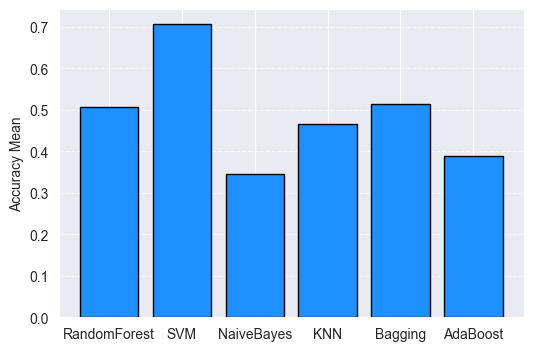

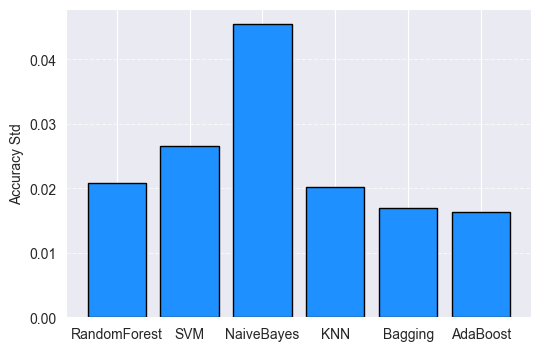

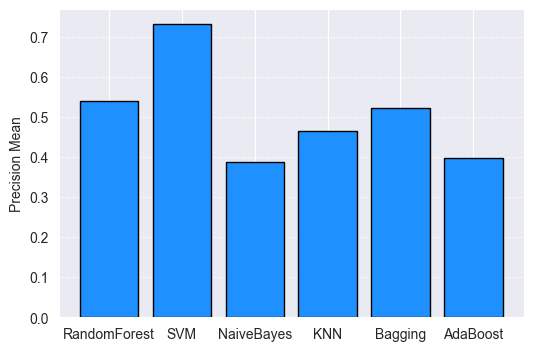

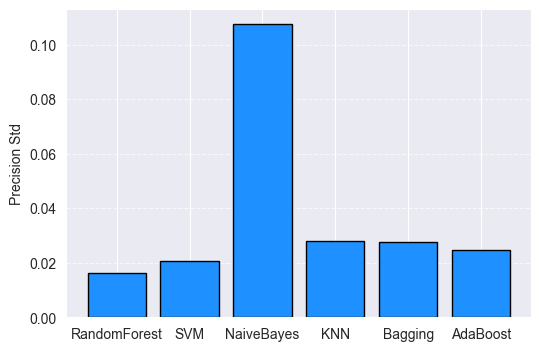

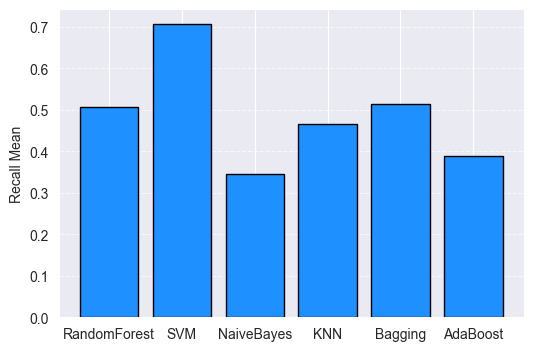

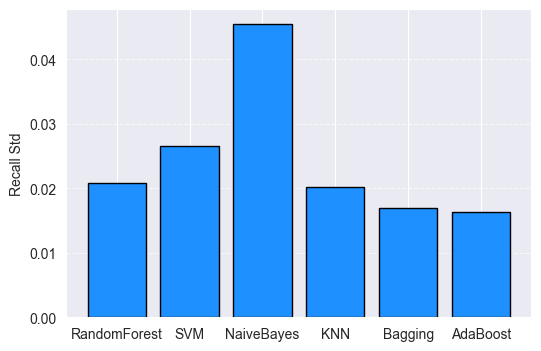

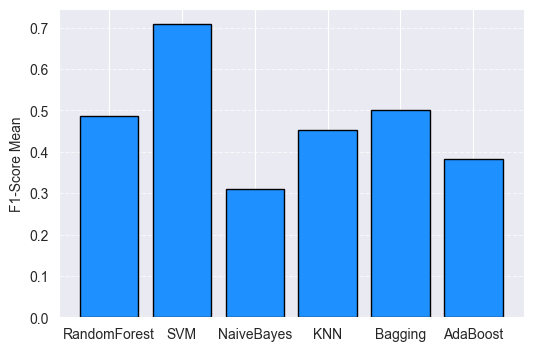

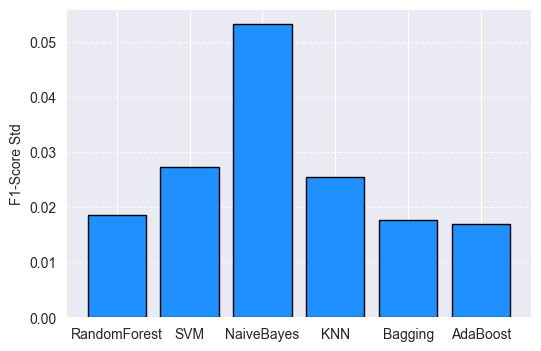

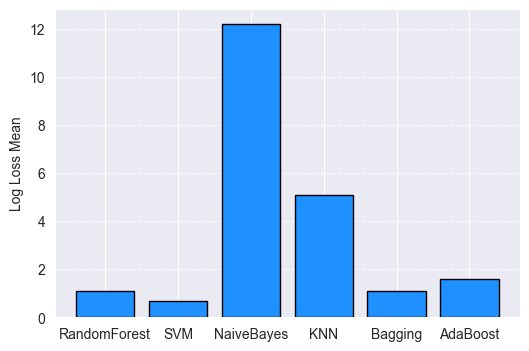

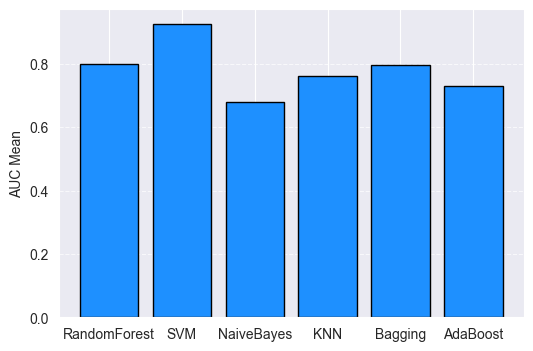

In [30]:
from matplotlib import pyplot as plt

for metric in df_results.columns[1:]:
    plt.figure(figsize=(6,4))
    plt.bar(df_results["Model"], df_results[metric], color="dodgerblue", edgecolor="black")
    plt.ylabel(metric)
    plt.xticks(rotation=0)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.savefig(f'MinMaxScaler{metric}.png', dpi=300)
    plt.show()

In [38]:
df_class_results

,Model,Class,Precision,Recall,F1-Score
0,RandomForest,0,0.373913,0.716667,0.491429
1,RandomForest,1,0.909091,0.333333,0.487805
2,RandomForest,2,0.435897,0.340000,0.382022
3,RandomForest,3,0.400000,0.150000,0.218182
4,RandomForest,4,1.000000,1.000000,1.000000
...,...,...,...,...,...
145,AdaBoost,0,0.352273,0.516667,0.418919
146,AdaBoost,1,0.611111,0.366667,0.458333
147,AdaBoost,2,0.363636,0.320000,0.340426
148,AdaBoost,3,0.166667,0.125000,0.142857


Najlepszy model: SVM z wynikiem F1-Score = 0.7513675750436191
Najgorszy model: NaiveBayes z wynikiem F1-Score = 0.3907158570367805


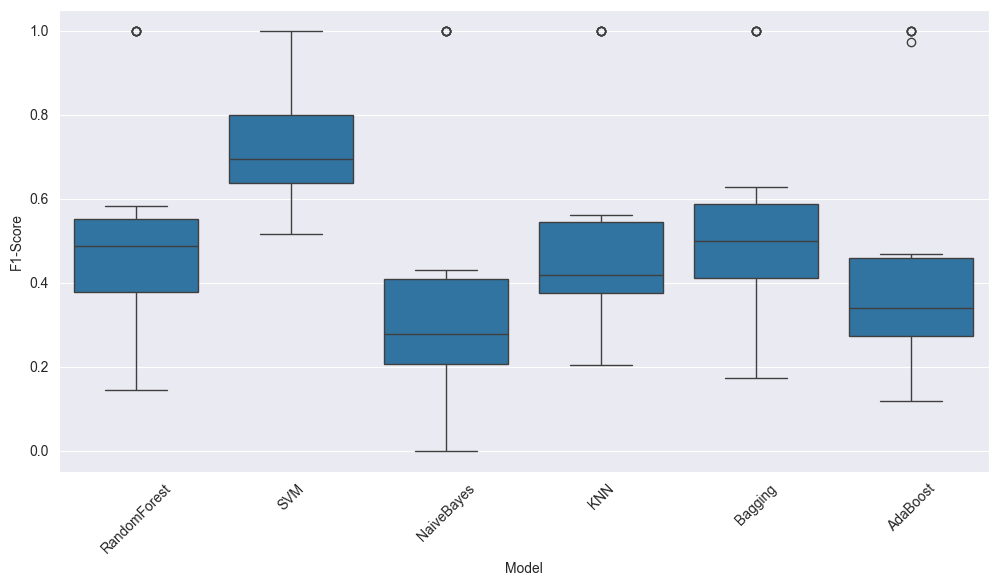

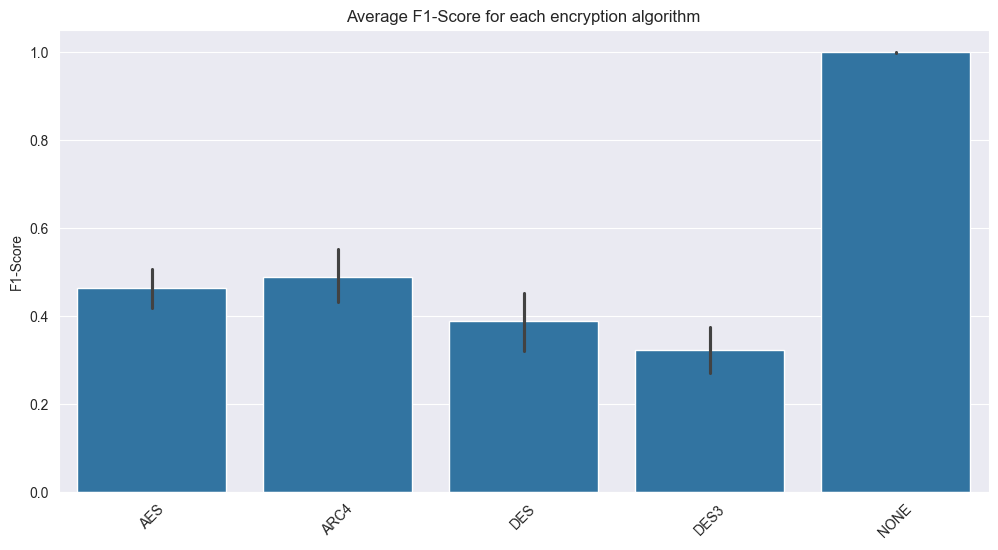

In [40]:
model_scores = df_class_results.groupby("Model")["F1-Score"].mean().sort_values(ascending=False)

best_model = model_scores.idxmax()
worst_model = model_scores.idxmin()
print(f"Najlepszy model: {best_model} z wynikiem F1-Score = {model_scores.max()}")
print(f"Najgorszy model: {worst_model} z wynikiem F1-Score = {model_scores.min()}")

plt.figure(figsize=(12,6))
sns.boxplot(x="Model", y="F1-Score", data=df_class_results)
plt.xticks(rotation=45)
plt.ylabel("F1-Score")
plt.show()

class_scores = df_class_results.groupby("Class")["F1-Score"].mean().sort_values(ascending=False)
plt.figure(figsize=(12,6))
sns.barplot(x=encoder.classes_[df_class_results["Class"]], y="F1-Score", data=df_class_results)
plt.xticks(rotation=45)
plt.title("Average F1-Score for each encryption algorithm")
plt.ylabel("F1-Score")
plt.show()

Data after StandardScaler

In [31]:
import pandas as pd

data_frame_standard_scaler = pd.read_csv('encrypted_features_txt_1000_ecb.csv')

from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
data_frame_standard_scaler['algorithm'] = encoder.fit_transform(data_frame_standard_scaler['algorithm'])
print(encoder.classes_)

from sklearn.preprocessing import StandardScaler

X = data_frame_standard_scaler.drop(columns=["algorithm", "file_name"])
y = data_frame_standard_scaler["algorithm"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

['AES' 'ARC4' 'DES' 'DES3' 'NONE']


In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    log_loss, roc_auc_score
)

# Definicja modeli
models = {
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": SVC(kernel="linear", probability=True),
    "NaiveBayes": GaussianNB(),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Bagging": BaggingClassifier(n_estimators=50, random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=50, random_state=42)
}

# Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Listy na wyniki
results_list = []
class_results = {model_name: [] for model_name in models}

# Trenowanie i ewaluacja modeli
for model_name, model in models.items():
    acc_scores, precision_scores, recall_scores, f1_scores = [], [], [], []
    log_losses, auc_scores = [], []
    
    for train_index, test_index in skf.split(X_scaled, y):
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]  # dla pandas.DataFrame
        y_train, y_test = y[train_index], y[test_index]

        # Trenowanie modelu
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test) if hasattr(model, "predict_proba") else None

        # Obliczanie metryk ogólnych
        acc_scores.append(accuracy_score(y_test, y_pred))
        precision_scores.append(precision_score(y_test, y_pred, average='weighted'))
        recall_scores.append(recall_score(y_test, y_pred, average='weighted'))
        f1_scores.append(f1_score(y_test, y_pred, average='weighted'))

        if y_pred_proba is not None:
            log_losses.append(log_loss(y_test, y_pred_proba))
            auc_scores.append(roc_auc_score(y_test, y_pred_proba, multi_class="ovr"))
        else:
            log_losses.append(None)
            auc_scores.append(None)

        # Obliczanie metryk dla każdej klasy osobno
        class_precision = precision_score(y_test, y_pred, average=None)
        class_recall = recall_score(y_test, y_pred, average=None)
        class_f1 = f1_score(y_test, y_pred, average=None)

        for i, class_label in enumerate(np.unique(y)):
            class_results[model_name].append({
                "Class": class_label,
                "Precision": class_precision[i],
                "Recall": class_recall[i],
                "F1-Score": class_f1[i]
            })

    # Agregacja wyników ogólnych
    results_list.append({
        "Model": model_name,
        "Accuracy Mean": np.mean(acc_scores),
        "Accuracy Std": np.std(acc_scores),
        "Precision Mean": np.mean(precision_scores),
        "Precision Std": np.std(precision_scores),
        "Recall Mean": np.mean(recall_scores),
        "Recall Std": np.std(recall_scores),
        "F1-Score Mean": np.mean(f1_scores),
        "F1-Score Std": np.std(f1_scores),
        "Log Loss Mean": np.mean([x for x in log_losses if x is not None]) if any(log_losses) else None,
        "AUC Mean": np.mean([x for x in auc_scores if x is not None]) if any(auc_scores) else None
    })

# Konwersja wyników do DataFrame
df_results = pd.DataFrame(results_list)
df_class_results = pd.DataFrame([
    {"Model": model, **result} for model, results in class_results.items() for result in results
])

# Wyświetlenie tabeli w Jupyter Notebook
df_results.style.format("{:.4f}"), df_class_results.style.format("{:.4f}")


/Users/jakubkowalewski/Desktop/pythonProject-main/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jakubkowalewski/Desktop/pythonProject-main/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jakubkowalewski/Desktop/pythonProject-main/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

(<pandas.io.formats.style.Styler at 0x16ae5e280>,
 <pandas.io.formats.style.Styler at 0x14fef17f0>)

In [33]:
df_results

,Model,Accuracy Mean,Accuracy Std,Precision Mean,Precision Std,Recall Mean,Recall Std,F1-Score Mean,F1-Score Std,Log Loss Mean,AUC Mean
0,RandomForest,0.509,0.026153,0.546153,0.021080,0.509,0.026153,0.489067,0.024403,1.113981,0.798422
1,SVM,0.667,0.019391,0.679481,0.019405,0.667,0.019391,0.668763,0.019546,0.744229,0.908025
2,NaiveBayes,0.345,0.045497,0.387331,0.107580,0.345,0.045497,0.310592,0.053292,12.201061,0.678645
3,KNN,0.475,0.028107,0.479751,0.043546,0.475,0.028107,0.460480,0.032055,4.870412,0.765504
4,Bagging,0.512,0.019131,0.523983,0.026824,0.512,0.019131,0.501196,0.019739,1.078751,0.796999
5,AdaBoost,0.388,0.016310,0.397772,0.024527,0.388,0.016310,0.383317,0.016893,1.586909,0.729728


In [34]:
# Słownik mapujący oryginalne nazwy na polskie
column_translation = {
    "Model": "Model",
    "Accuracy Mean": "Średnia dokładność",
    "Accuracy Std": "Odchylenie standardowe dokładności",
    "Precision Mean": "Średnia precyzja",
    "Precision Std": "Odchylenie standardowe precyzji",
    "Recall Mean": "Średnia czułość",
    "Recall Std": "Odchylenie standardowe czułości",
    "F1-Score Mean": "Średnia F1-Score",
    "F1-Score Std": "Odchylenie standardowe F1-Score",
    "Log Loss Mean": "Średnia strata logarytmiczna",
    "AUC Mean": "Średnia AUC"
}

# Zastosowanie tłumaczenia
df_polish = df_results.rename(columns=column_translation)

# Podgląd
print(df_polish.head())


          Model  Średnia dokładność  Odchylenie standardowe dokładności  \
0  RandomForest               0.509                            0.026153   
1           SVM               0.667                            0.019391   
2    NaiveBayes               0.345                            0.045497   
3           KNN               0.475                            0.028107   
4       Bagging               0.512                            0.019131   

   Średnia precyzja  Odchylenie standardowe precyzji  Średnia czułość  \
0          0.546153                         0.021080            0.509   
1          0.679481                         0.019405            0.667   
2          0.387331                         0.107580            0.345   
3          0.479751                         0.043546            0.475   
4          0.523983                         0.026824            0.512   

   Odchylenie standardowe czułości  Średnia F1-Score  \
0                         0.026153          0.489067  

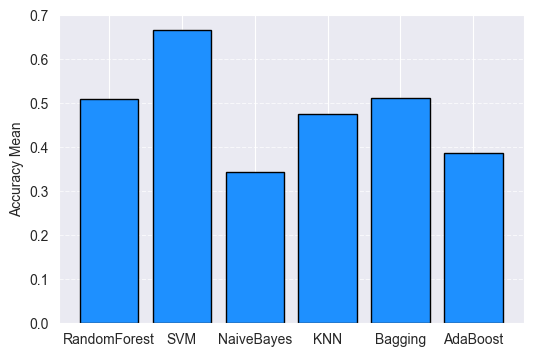

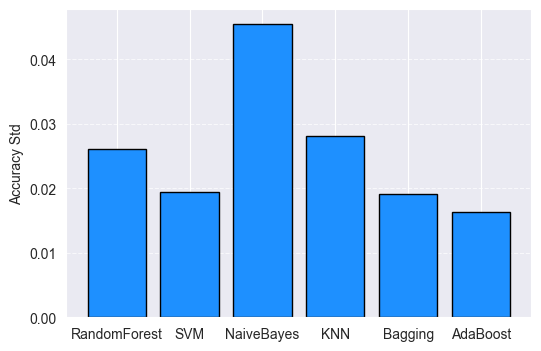

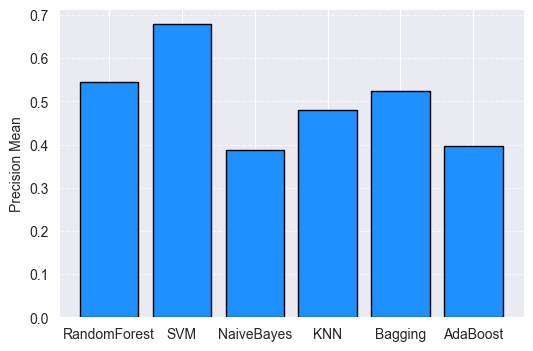

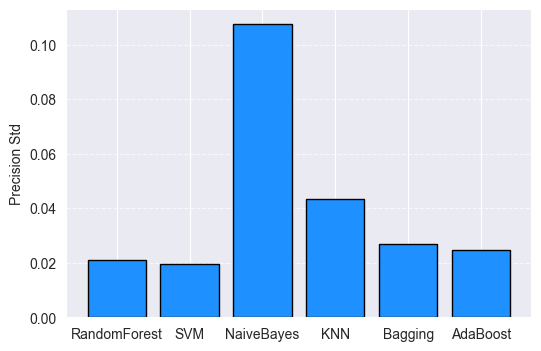

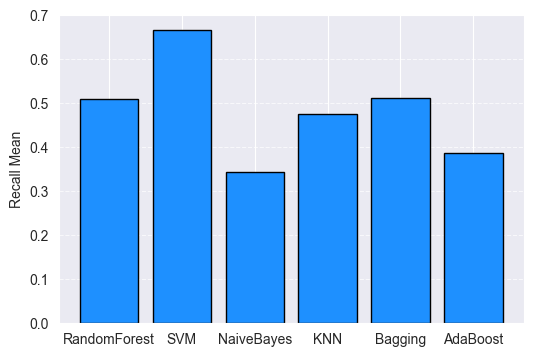

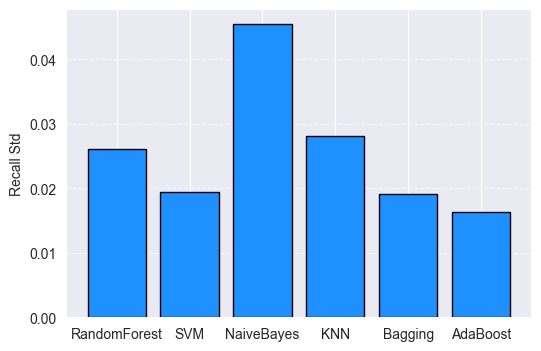

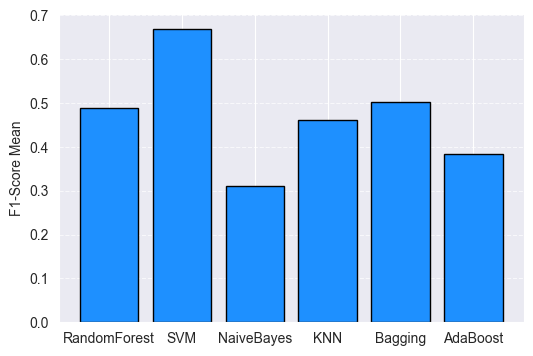

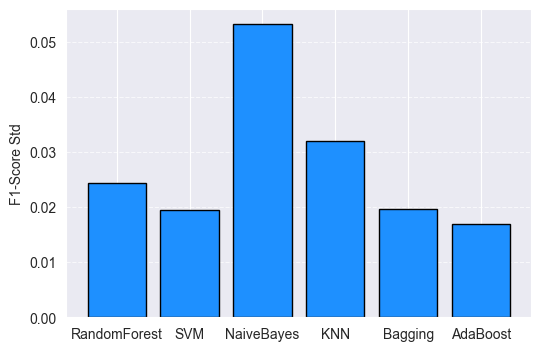

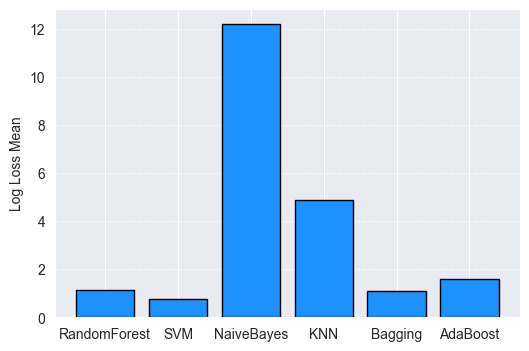

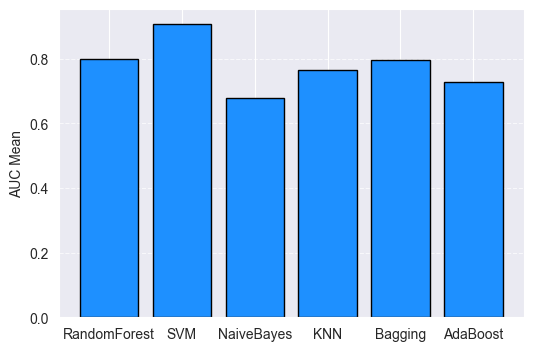

In [35]:
for metric in df_results.columns[1:]:
    plt.figure(figsize=(6,4))
    plt.bar(df_results["Model"], df_results[metric], color="dodgerblue", edgecolor="black")
    plt.ylabel(metric)
    plt.xticks(rotation=0)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.savefig(f'StandardScaler{metric}.png', dpi=300)
    plt.show()

In [23]:
df_class_results

,Model,Class,Precision,Recall,F1-Score
0,RandomForest,0,0.420000,0.700000,0.525000
1,RandomForest,1,0.600000,0.400000,0.480000
2,RandomForest,2,0.416667,0.400000,0.408163
3,RandomForest,3,0.166667,0.050000,0.076923
4,RandomForest,4,1.000000,1.000000,1.000000
5,RandomForest,0,0.410000,0.683333,0.512500
6,RandomForest,1,0.656250,0.700000,0.677419
7,RandomForest,2,0.514286,0.360000,0.423529
8,RandomForest,3,0.307692,0.100000,0.150943
9,RandomForest,4,1.000000,1.000000,1.000000


Najlepszy model: SVM z wynikiem F1-Score = 0.7211523437108609
Najgorszy model: NaiveBayes z wynikiem F1-Score = 0.3907158570367805


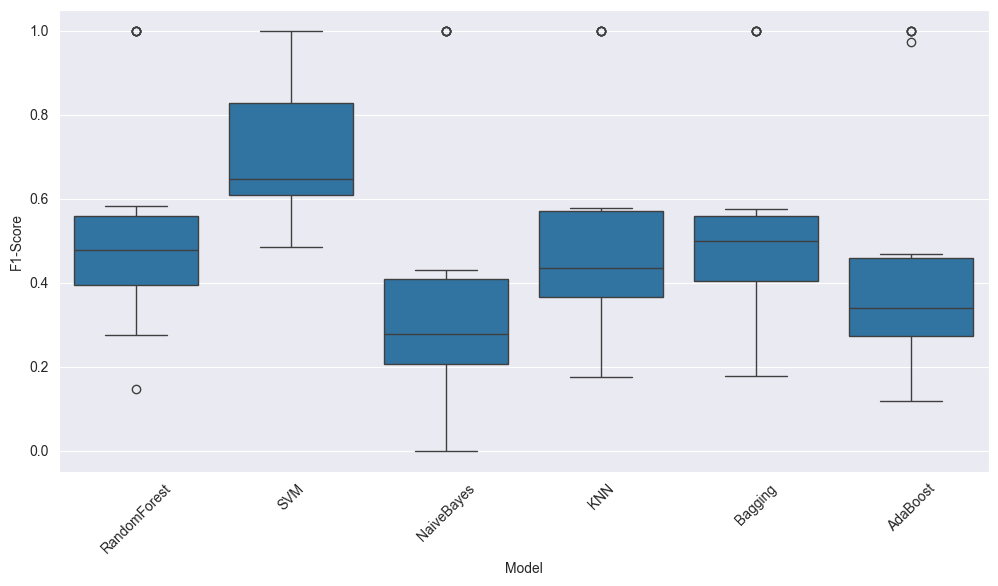

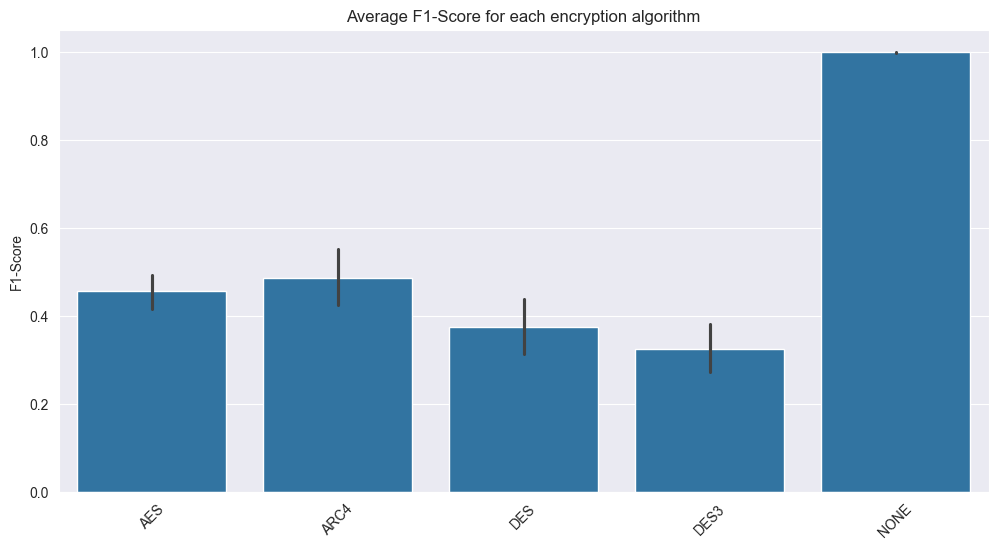

In [55]:
model_scores = df_class_results.groupby("Model")["F1-Score"].mean().sort_values(ascending=False)

best_model = model_scores.idxmax()
worst_model = model_scores.idxmin()
print(f"Najlepszy model: {best_model} z wynikiem F1-Score = {model_scores.max()}")
print(f"Najgorszy model: {worst_model} z wynikiem F1-Score = {model_scores.min()}")

plt.figure(figsize=(12,6))
sns.boxplot(x="Model", y="F1-Score", data=df_class_results)
plt.xticks(rotation=45)
plt.ylabel("F1-Score")
plt.show()

class_scores = df_class_results.groupby("Class")["F1-Score"].mean().sort_values(ascending=False)
plt.figure(figsize=(12,6))
sns.barplot(x=encoder.classes_[df_class_results["Class"]], y="F1-Score", data=df_class_results)
plt.xticks(rotation=45)
plt.title("Average F1-Score for each encryption algorithm")
plt.ylabel("F1-Score")
plt.show()

Best model: SVM with F1-Score = 0.7000925869911571
Worst model: NaiveBayes with F1-Score = 0.44903914946313095


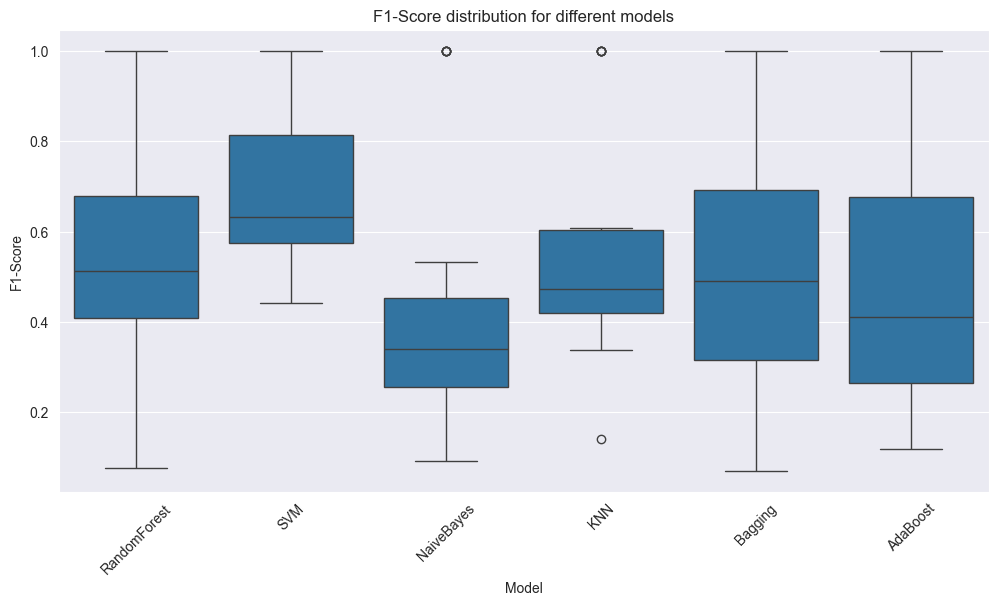

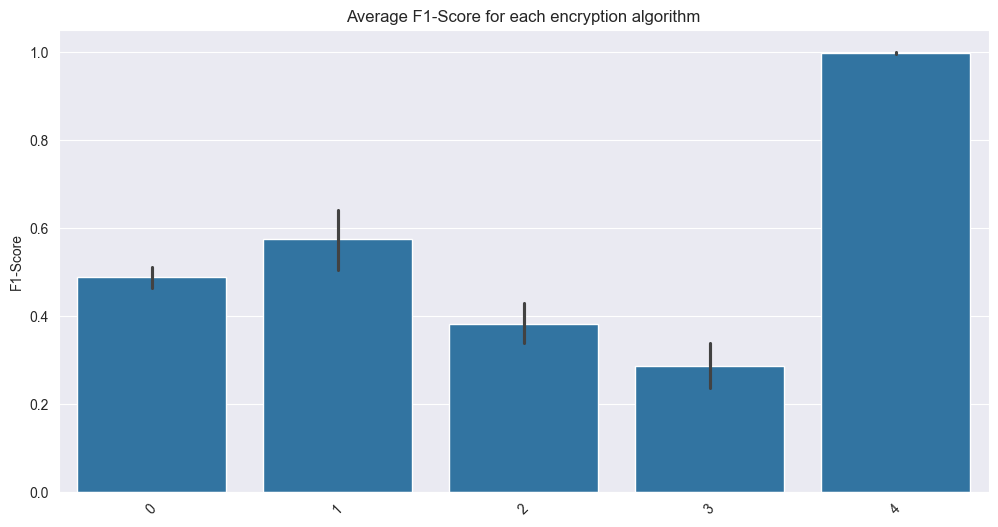

In [25]:
model_scores = df_class_results.groupby("Model")["F1-Score"].mean().sort_values(ascending=False)

best_model = model_scores.idxmax()
worst_model = model_scores.idxmin()
print(f"Best model: {best_model} with F1-Score = {model_scores.max()}")
print(f"Worst model: {worst_model} with F1-Score = {model_scores.min()}")

plt.figure(figsize=(12,6))
sns.boxplot(x="Model", y="F1-Score", data=df_class_results)
plt.xticks(rotation=45)
plt.title("F1-Score distribution for different models")
plt.ylabel("F1-Score")
plt.show()

class_scores = df_class_results.groupby("Class")["F1-Score"].mean().sort_values(ascending=False)
plt.figure(figsize=(12,6))
sns.barplot(x=encoder.classes_[df_class_results["Class"]], y="F1-Score", data=df_class_results)
plt.xticks(rotation=45)
plt.title("Average F1-Score for each encryption algorithm")
plt.ylabel("F1-Score")
plt.show()

In [56]:
import pandas as pd

data_frame = pd.read_csv('encrypted_features_txt_1000_ecb.csv')
data_frame

,file_name,entropy,mean,variance,std_dev,skewness,kurtosis,energy,rms,histogram_0,...,histogram_247,histogram_248,histogram_249,histogram_250,histogram_251,histogram_252,histogram_253,histogram_254,histogram_255,algorithm
0,file0359.txt.enc,7.874751,126.502703,5426.840533,73.667093,0.010801,-1.201622,159202,10.371544,3,...,4,6,5,6,4,7,4,4,2,DES
1,file0349.txt.enc,7.947062,126.474722,5538.406583,74.420472,0.028584,-1.196003,379535,10.267735,14,...,21,14,19,21,13,14,11,15,10,DES
2,file0474.txt.enc,7.976434,128.381337,5502.731549,74.180399,-0.003547,-1.203000,963290,10.259366,40,...,44,42,36,43,38,42,37,34,48,DES
3,file0464.txt.enc,7.894732,125.666492,5459.260096,73.886806,0.046188,-1.204116,193215,10.073652,6,...,5,4,11,7,7,8,8,11,5,DES
4,file0416.txt.enc,7.975843,128.416190,5454.062770,73.851627,-0.012061,-1.186151,740818,10.293310,23,...,28,29,31,31,35,25,31,30,29,DES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,file0058.txt.enc,7.979534,127.781647,5522.520040,74.313660,-0.010099,-1.211684,924013,10.237720,34,...,35,36,33,49,38,37,36,32,31,AES
996,file0256.txt.enc,7.974408,126.648401,5417.036698,73.600521,0.019118,-1.189063,721141,10.238018,30,...,22,31,36,27,35,25,25,15,24,AES
997,file0246.txt.enc,7.919591,127.221000,5233.212159,72.340944,0.018650,-1.162764,215862,10.388985,7,...,8,4,7,3,5,8,9,8,5,AES
998,file0189.txt.enc,7.834612,128.444079,5493.592268,74.118771,0.025633,-1.167368,128384,10.275162,6,...,5,8,1,7,7,4,9,6,13,AES


In [57]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
data_frame['algorithm'] = encoder.fit_transform(data_frame['algorithm'])
print(encoder.classes_)

['AES' 'ARC4' 'DES' 'DES3' 'NONE']


In [58]:
from sklearn.preprocessing import MinMaxScaler

X = data_frame.drop(columns=["algorithm", "file_name"])
y = data_frame["algorithm"]

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [59]:
import pandas as pd
import numpy as np
from itertools import product
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    log_loss, roc_auc_score
)

model_params = {
    "RandomForest": {
        "n_estimators": [50, 100, 200],
        "max_depth": [None, 10, 20],
        "min_samples_split": [2, 5],
        "min_samples_leaf": [1, 2],
        "max_features": ["sqrt", "log2", None]  
    },
    "SVM": {
        "kernel": ["linear", "rbf", "poly", "sigmoid"],
        "C": [0.1, 1, 10],
        "gamma": ["scale", "auto"],
        "degree": [3, 4, 5],
        "coef0": [0, 0.1, 1]
    },
    "NaiveBayes": {
        "var_smoothing": [1e-9, 1e-8, 1e-7]
    },
    "KNN": {
        "n_neighbors": [3, 5, 7, 10],
        "weights": ["uniform", "distance"],
        "metric": ["euclidean", "manhattan", "minkowski"]
    },
    "Bagging": {
        "n_estimators": [10, 50, 100],
        "max_samples": [0.5, 0.8, 1.0],
        "max_features": [0.5, 0.8, 1.0]
    },
    "AdaBoost": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.01, 0.1, 1.0]
    }
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results_list = []
class_results = []

for model_name, param_grid in model_params.items():
    param_combinations = [dict(zip(param_grid.keys(), values)) for values in product(*param_grid.values())] or [{}]

    for params in param_combinations:
        if model_name == "RandomForest":
            model = RandomForestClassifier(**params, random_state=42)
        elif model_name == "SVM":
            model = SVC(**params, probability=True, random_state=42)
        elif model_name == "NaiveBayes":
            model = GaussianNB()
        elif model_name == "KNN":
            model = KNeighborsClassifier(**params)
        elif model_name == "Bagging":
            model = BaggingClassifier(**params, random_state=42)
        elif model_name == "AdaBoost":
            model = AdaBoostClassifier(**params, random_state=42)

        acc_scores, precision_scores, recall_scores, f1_scores = [], [], [], []
        log_losses, auc_scores = [], []

        for train_index, test_index in skf.split(X_scaled, y):
            X_train, X_test = X_scaled[train_index], X_scaled[test_index]
            y_train, y_test = y[train_index], y[test_index]

            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            y_pred_proba = model.predict_proba(X_test) if hasattr(model, "predict_proba") else None

            acc_scores.append(accuracy_score(y_test, y_pred))
            precision_scores.append(precision_score(y_test, y_pred, average='weighted'))
            recall_scores.append(recall_score(y_test, y_pred, average='weighted'))
            f1_scores.append(f1_score(y_test, y_pred, average='weighted'))

            if y_pred_proba is not None:
                log_losses.append(log_loss(y_test, y_pred_proba))
                auc_scores.append(roc_auc_score(y_test, y_pred_proba, multi_class="ovr"))
            else:
                log_losses.append(None)
                auc_scores.append(None)

            class_precision = precision_score(y_test, y_pred, average=None)
            class_recall = recall_score(y_test, y_pred, average=None)
            class_f1 = f1_score(y_test, y_pred, average=None)

            for i, class_label in enumerate(np.unique(y)):
                class_results.append({
                    "Model": model_name,
                    "Params": str(params),
                    "Class": class_label,
                    "Precision": class_precision[i],
                    "Recall": class_recall[i],
                    "F1-Score": class_f1[i]
                })

        # Agregacja wyników ogólnych
        results_list.append({
            "Model": model_name,
            "Params": str(params),
            "Accuracy Mean": np.mean(acc_scores),
            "Accuracy Std": np.std(acc_scores),
            "Precision Mean": np.mean(precision_scores),
            "Precision Std": np.std(precision_scores),
            "Recall Mean": np.mean(recall_scores),
            "Recall Std": np.std(recall_scores),
            "F1-Score Mean": np.mean(f1_scores),
            "F1-Score Std": np.std(f1_scores),
            "Log Loss Mean": np.mean([x for x in log_losses if x is not None]) if any(log_losses) else None,
            "AUC Mean": np.mean([x for x in auc_scores if x is not None]) if any(auc_scores) else None
        })

df_results = pd.DataFrame(results_list)
df_class_results = pd.DataFrame(class_results)

df_results.to_csv("model_results.csv", index=False)
df_class_results.to_csv("class_results.csv", index=False)

df_results.style.format("{:.4f}"), df_class_results.style.format("{:.4f}")


/Users/jakubkowalewski/Desktop/pythonProject-main/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jakubkowalewski/Desktop/pythonProject-main/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jakubkowalewski/Desktop/pythonProject-main/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

(<pandas.io.formats.style.Styler at 0x305569400>,
 <pandas.io.formats.style.Styler at 0x3053670d0>)

In [1]:
import pandas as pd
df_results = pd.DataFrame(pd.read_csv("model_results.csv"))
df_results

,Model,Params,Accuracy Mean,Accuracy Std,Precision Mean,Precision Std,Recall Mean,Recall Std,F1-Score Mean,F1-Score Std,Log Loss Mean,AUC Mean
0,RandomForest,"{'n_estimators': 50, 'max_depth': None, 'min_s...",0.475,0.020976,0.508348,0.026312,0.475,0.020976,0.458025,0.019744,1.130095,0.776936
1,RandomForest,"{'n_estimators': 50, 'max_depth': None, 'min_s...",0.449,0.025768,0.459308,0.036366,0.449,0.025768,0.425790,0.028032,1.158496,0.750878
2,RandomForest,"{'n_estimators': 50, 'max_depth': None, 'min_s...",0.519,0.018547,0.528387,0.017789,0.519,0.018547,0.509541,0.018887,1.072502,0.801791
3,RandomForest,"{'n_estimators': 50, 'max_depth': None, 'min_s...",0.473,0.030265,0.504563,0.040868,0.473,0.030265,0.453332,0.032318,1.129880,0.776549
4,RandomForest,"{'n_estimators': 50, 'max_depth': None, 'min_s...",0.459,0.021307,0.494929,0.025048,0.459,0.021307,0.434334,0.021604,1.141312,0.772012
...,...,...,...,...,...,...,...,...,...,...,...,...
382,AdaBoost,"{'n_estimators': 100, 'learning_rate': 0.1}",0.403,0.008124,0.287926,0.016685,0.403,0.008124,0.326126,0.017732,1.570540,0.707240
383,AdaBoost,"{'n_estimators': 100, 'learning_rate': 1.0}",0.439,0.030561,0.442906,0.040495,0.439,0.030561,0.430867,0.028236,1.589102,0.750996
384,AdaBoost,"{'n_estimators': 200, 'learning_rate': 0.01}",0.400,0.000000,0.200000,0.000000,0.400,0.000000,0.250000,0.000000,1.560097,0.652594
385,AdaBoost,"{'n_estimators': 200, 'learning_rate': 0.1}",0.418,0.005099,0.376845,0.054778,0.418,0.005099,0.356887,0.012920,1.576634,0.724293


In [3]:
import pandas as pd

# Zakładamy, że df_results jest już wczytany
# df_results = pd.read_csv("Out_1.csv")

# Grupowanie po modelu i obliczanie średnich oraz odchyleń standardowych
agg_metrics = {
    "Accuracy Mean": ["mean", "std"],
    "Precision Mean": ["mean", "std"],
    "Recall Mean": ["mean", "std"],
    "F1-Score Mean": ["mean", "std"],
    "Log Loss Mean": ["mean"],
    "AUC Mean": ["mean"]
}

# Grupowanie i agregacja
summary_stats = df_results.groupby("Model").agg(agg_metrics)
summary_stats.columns = [' '.join(col).strip() for col in summary_stats.columns.values]
summary_stats = summary_stats.round(4).reset_index()

# Tłumaczenie nazw kolumn
summary_stats = summary_stats.rename(columns={
    "Model": "Model",
    "Accuracy Mean mean": "Średnia dokładność",
    "Accuracy Mean std": "Odchylenie dokładności",
    "Precision Mean mean": "Średnia precyzja",
    "Precision Mean std": "Odchylenie precyzji",
    "Recall Mean mean": "Średnia czułość",
    "Recall Mean std": "Odchylenie czułości",
    "F1-Score Mean mean": "Średni F1-score",
    "F1-Score Mean std": "Odchylenie F1-score",
    "Log Loss Mean mean": "Średnia strata logarytmiczna",
    "AUC Mean mean": "Średni AUC"
})

# Wyświetlenie wyników
summary_stats

,Model,Średnia dokładność,Odchylenie dokładności,Średnia precyzja,Odchylenie precyzji,Średnia czułość,Odchylenie czułości,Średni F1-score,Odchylenie F1-score,Średnia strata logarytmiczna,Średni AUC
0,AdaBoost,0.4112,0.0214,0.3078,0.1137,0.4112,0.0214,0.3270,0.0814,1.5725,0.7041
1,Bagging,0.4820,0.0325,0.4920,0.0408,0.4820,0.0325,0.4688,0.0315,1.4809,0.7806
2,KNN,0.4744,0.0130,0.4729,0.0110,0.4744,0.0130,0.4652,0.0127,4.9773,0.7617
3,NaiveBayes,0.3450,0.0000,0.3873,0.0000,0.3450,0.0000,0.3106,0.0000,12.2011,0.6787
4,RandomForest,0.4957,0.0239,0.5334,0.0259,0.4957,0.0239,0.4729,0.0309,1.1104,0.7964
5,SVM,0.4975,0.1425,0.4650,0.2613,0.4975,0.1425,0.4257,0.2032,0.9577,0.8383


In [61]:
df_class_results

,Model,Params,Class,Precision,Recall,F1-Score
0,RandomForest,"{'n_estimators': 50, 'max_depth': None, 'min_s...",0,0.358491,0.633333,0.457831
1,RandomForest,"{'n_estimators': 50, 'max_depth': None, 'min_s...",1,0.692308,0.300000,0.418605
2,RandomForest,"{'n_estimators': 50, 'max_depth': None, 'min_s...",2,0.400000,0.280000,0.329412
3,RandomForest,"{'n_estimators': 50, 'max_depth': None, 'min_s...",3,0.346154,0.225000,0.272727
4,RandomForest,"{'n_estimators': 50, 'max_depth': None, 'min_s...",4,1.000000,1.000000,1.000000
...,...,...,...,...,...,...
9670,AdaBoost,"{'n_estimators': 200, 'learning_rate': 1.0}",0,0.354430,0.466667,0.402878
9671,AdaBoost,"{'n_estimators': 200, 'learning_rate': 1.0}",1,0.578947,0.366667,0.448980
9672,AdaBoost,"{'n_estimators': 200, 'learning_rate': 1.0}",2,0.434783,0.400000,0.416667
9673,AdaBoost,"{'n_estimators': 200, 'learning_rate': 1.0}",3,0.388889,0.350000,0.368421
